In [4]:
import keras as k
from keras import models
from keras import layers
from keras import utils

def get_model(optimizer, loss_metric, metrics, lr=1e-3):
    img_height = 256
    img_width = 256
    img_channels = 3
    
    input_shape = (img_height, img_width, img_channels)
    img_input = k.Input(shape=input_shape)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='SAME')(img_input)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='SAME')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    drop1 = layers.Dropout(0.5)(pool1)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='SAME')(drop1)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='SAME')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = layers.Dropout(0.5)(pool2)
    
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='SAME')(drop2)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='SAME')(conv3)
    
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = layers.Dropout(0.3)(pool3)
    
    conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='SAME')(drop3)
    conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='SAME')(conv4)
    
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    drop4 = layers.Dropout(0.3)(pool4)
    
    conv5 = layers.Conv2D(512, (3, 3), activation='relu', padding='SAME')(drop4)
    conv5 = layers.Conv2D(512, (3, 3), activation='relu', padding='SAME')(conv5)
    
    
    conv5u = layers.Conv2DTranspose(filters=256, kernel_size=(2, 2), strides=(2, 2), padding='SAME')(conv5)
    
    up6 = layers.concatenate([conv5u, conv4], axis=3)
    conv6 = layers.Conv2D(256, (3, 3), activation='relu', padding='SAME')(up6)
    conv6 = layers.Conv2D(256, (3, 3), activation='relu', padding='SAME')(conv6)
    
    
    conv6u = layers.Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), padding='SAME')(conv6)
    
    up7 = layers.concatenate([conv6u, conv3], axis=3)
    conv7 = layers.Conv2D(128, (3, 3), activation='relu', padding='SAME')(up7)
    conv7 = layers.Conv2D(128, (3, 3), activation='relu', padding='SAME')(conv7)
    
    conv7u = layers.Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2, 2), padding='SAME')(conv7)
    
    up8 = layers.concatenate([conv7u, conv2], axis=3)
    conv8 = layers.Conv2D(64, (3, 3), activation='relu', padding='SAME')(up8)
    conv8 = layers.Conv2D(64, (3, 3), activation='relu', padding='SAME')(conv8)
    
    
    conv8u = layers.Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=(2, 2), padding='SAME')(conv8)
    
    up9 = layers.concatenate([conv8u, conv1], axis=3)
    conv9 = layers.Conv2D(32, (3, 3), activation='relu', padding='SAME')(up9)
    conv9 = layers.Conv2D(32, (3, 3), activation='relu', padding='SAME')(conv9)
    
    
    conv10 = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    
    
    model = models.Model(img_input, outputs=conv10)

    return model

In [11]:
smooth = 1.
# Dice Coefficient to work with Tensorflow
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

# Dice Coefficient to work outside Tensorflow
def dice_coef_2(y_true, y_pred):
    side = len(y_true[0])
    y_true_f = y_true.reshape(side*side)
    y_pred_f = y_pred.reshape(side*side)
    intersection = sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (sum(y_true_f) + sum(y_pred_f) + smooth)

In [6]:
opt = k.optimizers.Adam(learning_rate=1e-3)
model = get_model(optimizer=opt, loss_metric=dice_coef_loss, metrics=[dice_coef], lr=1e-3)

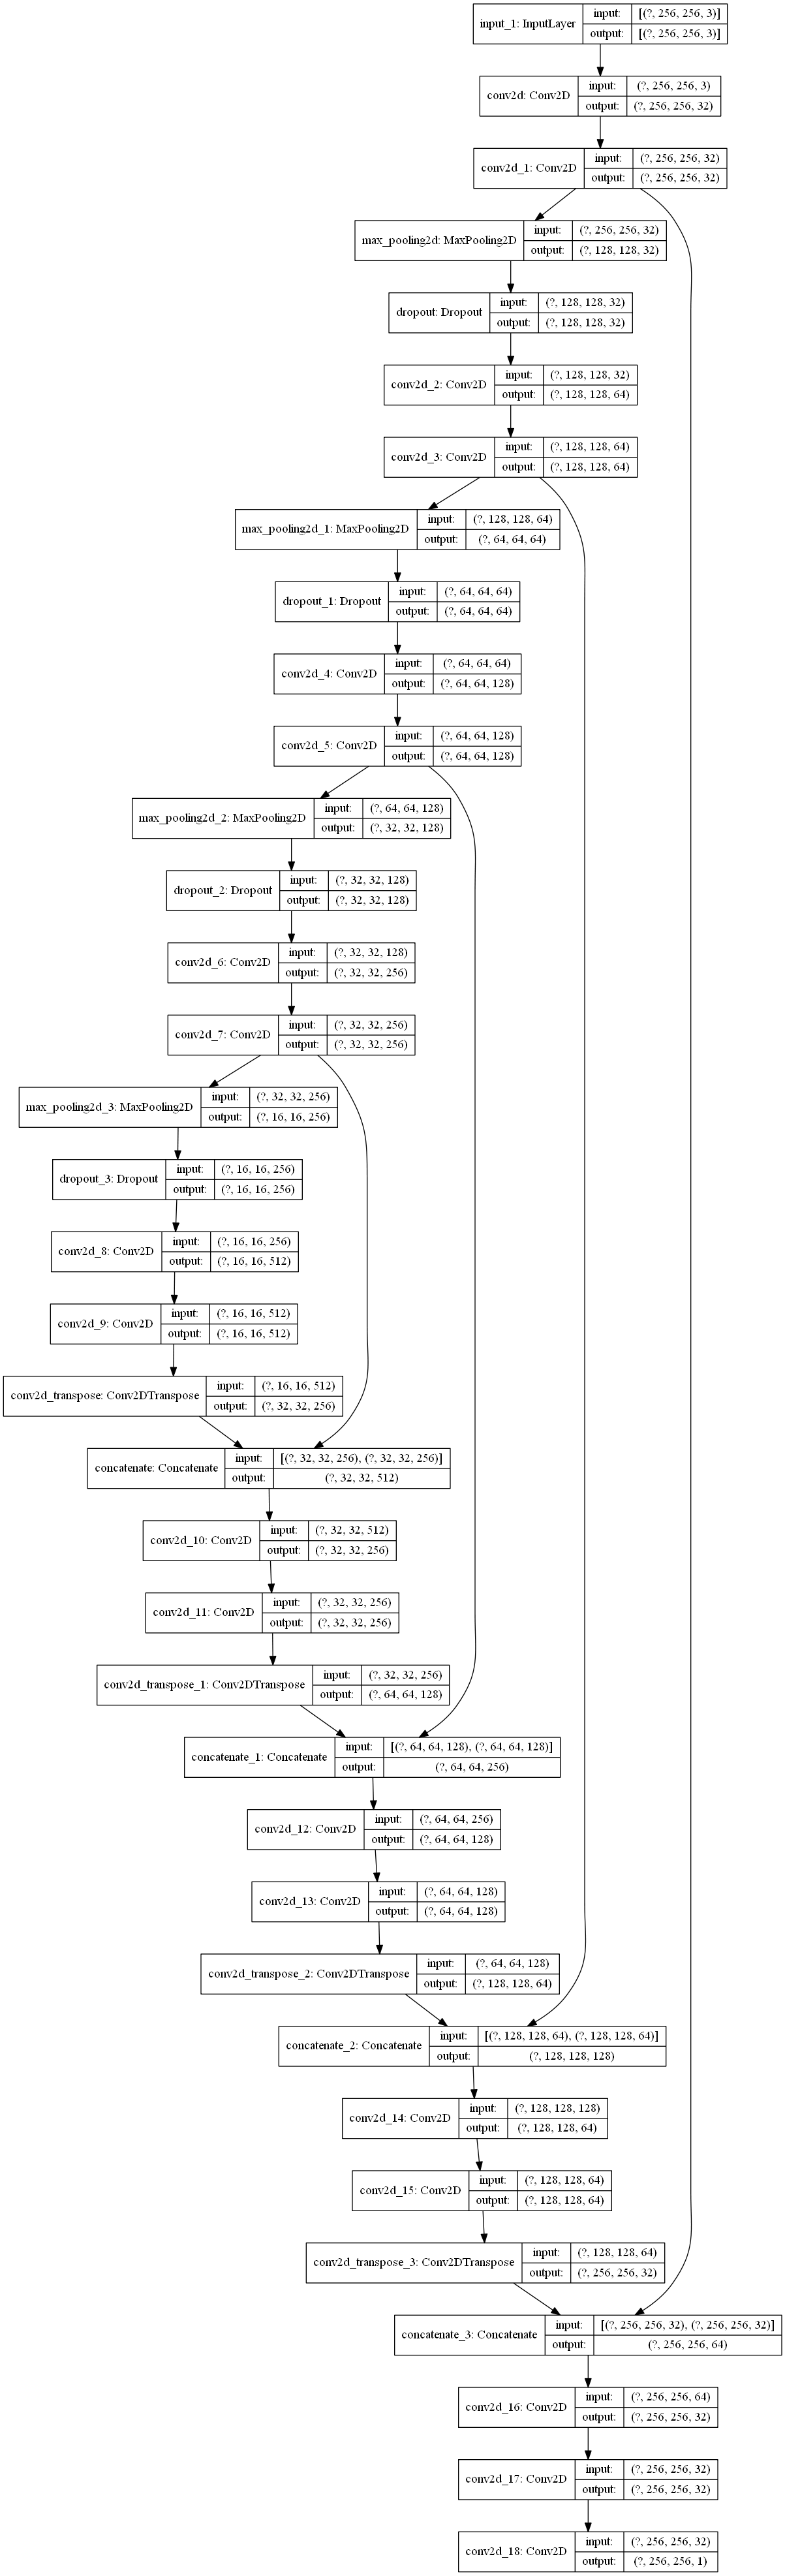

In [7]:
k.utils.plot_model(model,show_shapes=True,rankdir='TB')

In [11]:
import visualkeras

In [11]:
visualkeras.layered_view(model).show()

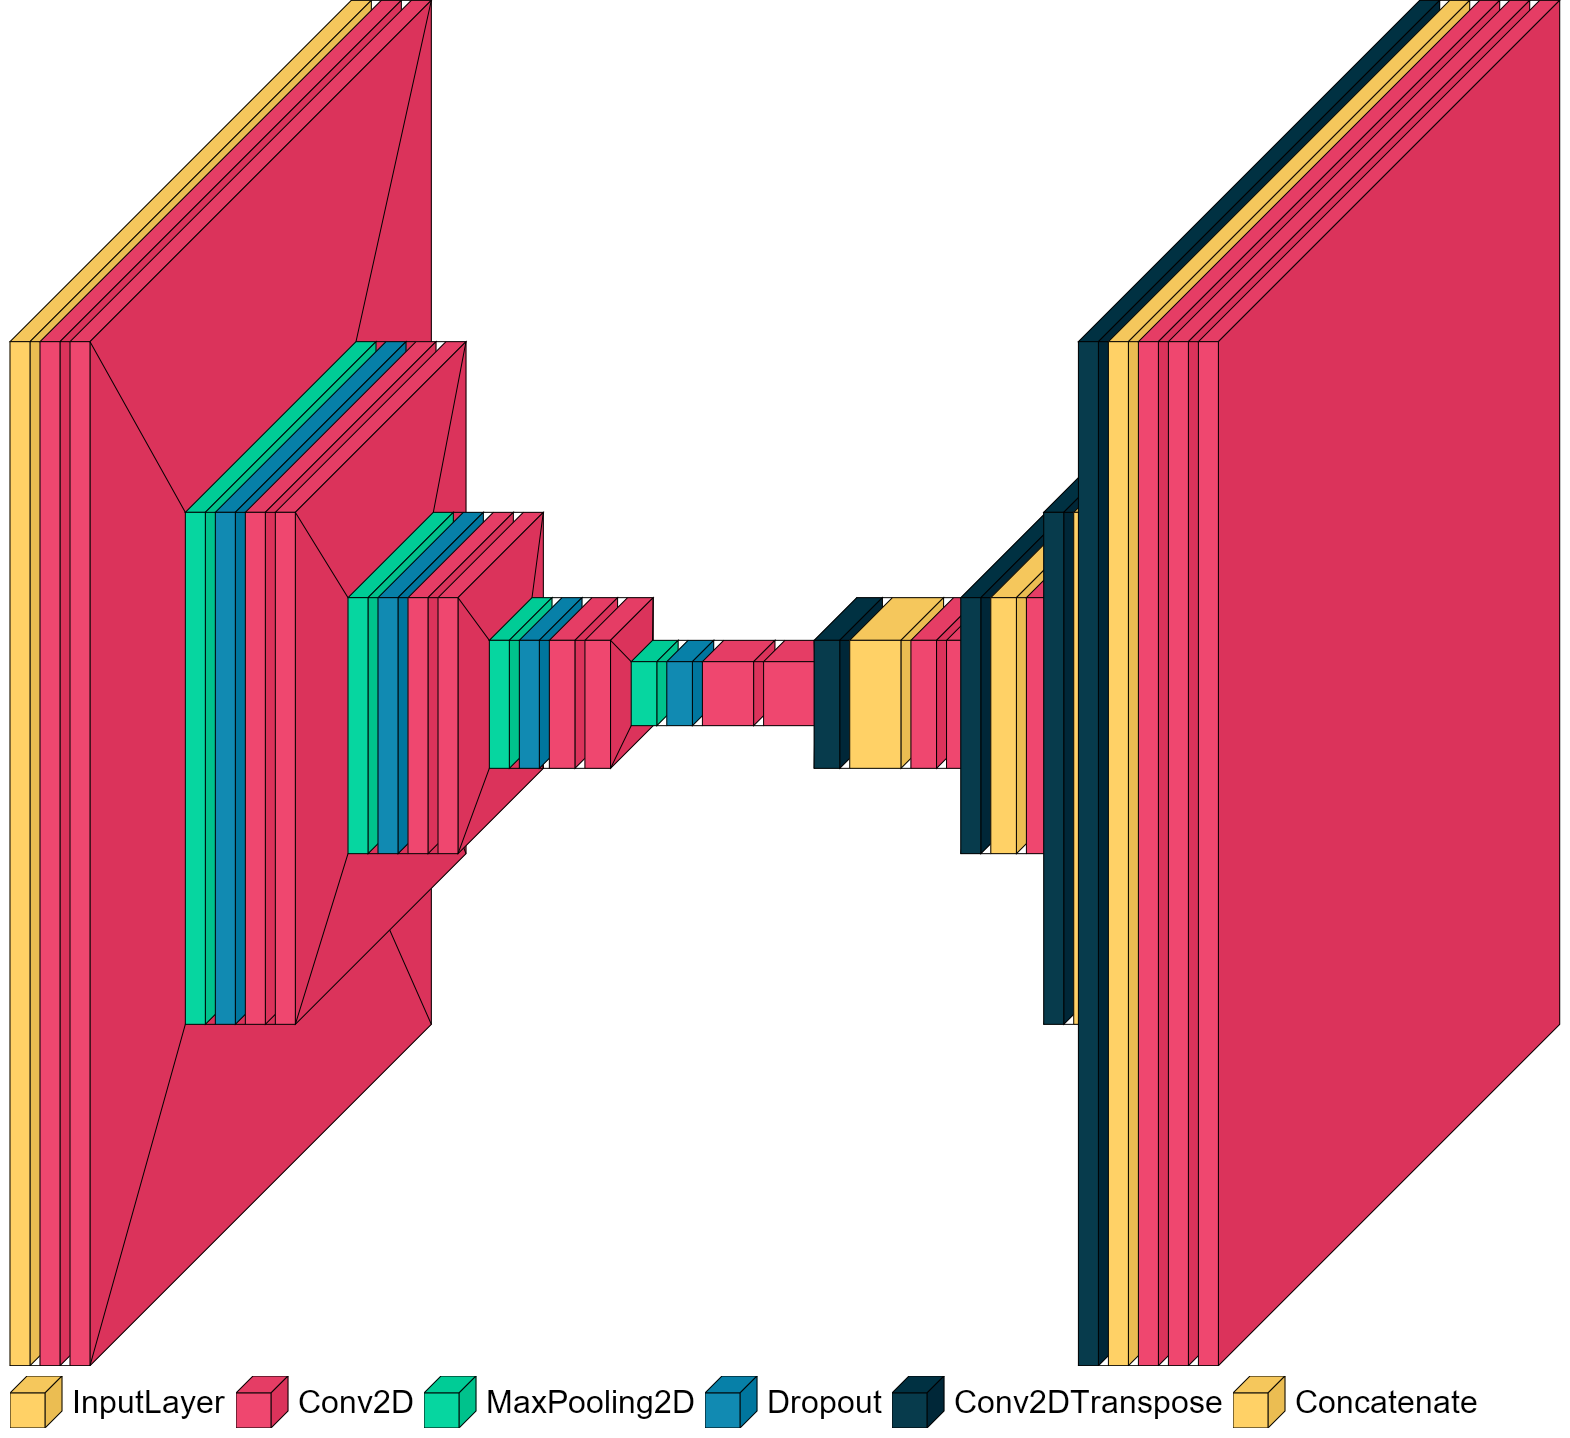

In [12]:
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
visualkeras.layered_view(model, legend=True, font=font)  # font is optional!

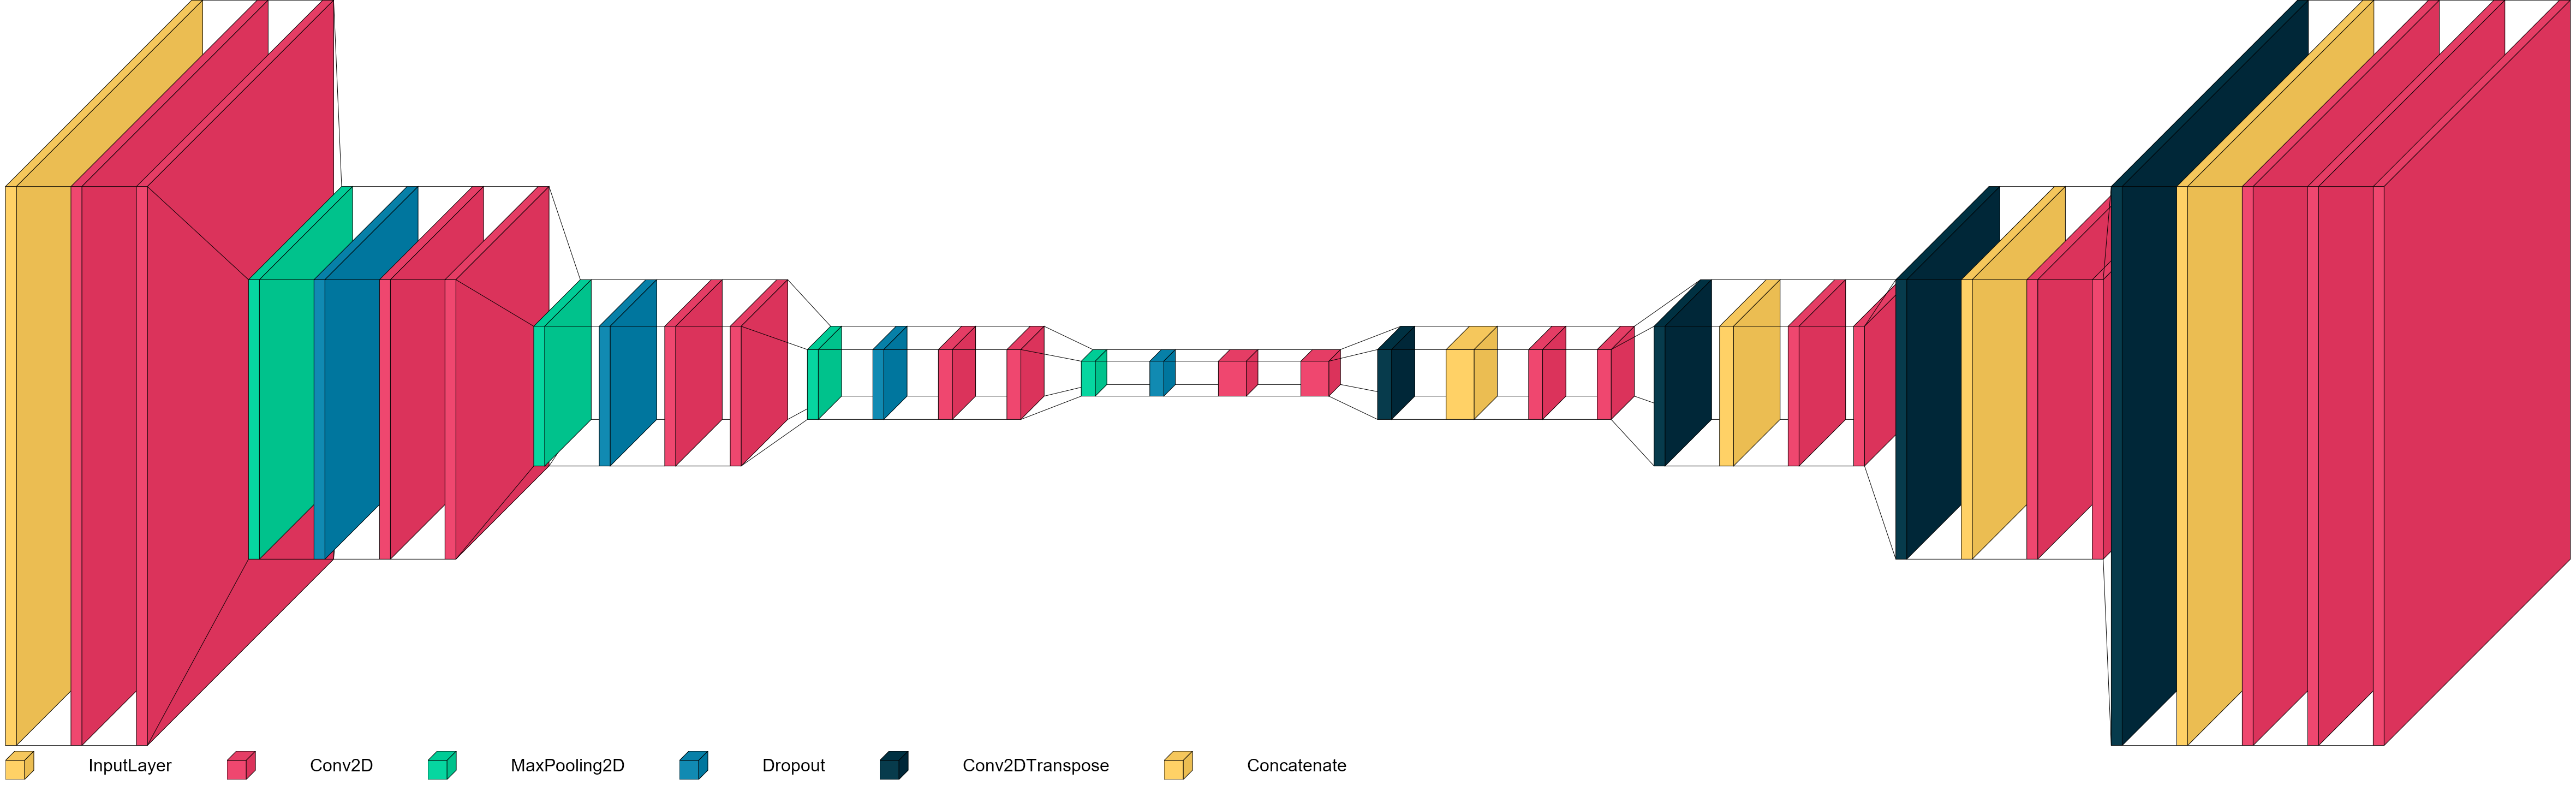

In [7]:
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 32)
visualkeras.layered_view(model, legend=True, font=font, spacing=100, to_file='output.png')

In [9]:
model.add(visualkeras.SpacingDummyLayer(spacing=100))

AttributeError: 'Functional' object has no attribute 'add'

# inverted residual layer

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, DepthwiseConv2D, BatchNormalization

class InvertedResidual(Layer):
    def __init__(self, filters, strides, expansion_factor=6, trainable=True,
    	         name=None, **kwargs):
        super(InvertedResidual, self).__init__(trainable=trainable, name=name, **kwargs)
        self.filters = filters
        self.strides = strides
        self.expansion_factor = expansion_factor	# allowed to be decimal value

    def build(self, input_shape):
        input_channels = int(input_shape[3])
        self.ptwise_conv1 = Conv2D(filters=int(input_channels*self.expansion_factor),
        	                       kernel_size=1, use_bias=False)
        self.dwise = DepthwiseConv2D(kernel_size=3, strides=self.strides,
        	                         padding='same', use_bias=False)
        self.ptwise_conv2 = Conv2D(filters=self.filters, kernel_size=1, use_bias=False)

        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()
        self.bn3 = BatchNormalization()

    def call(self, input_x):
        # Expansion to high-dimensional space
        x = self.ptwise_conv1(input_x)
        x = self.bn1(x)
        x = tf.nn.relu6(x)

        # Spatial filtering
        x = self.dwise(x)
        x = self.bn2(x)
        x = tf.nn.relu6(x)

        # Projection back to low-dimensional space w/ linear activation
        x = self.ptwise_conv2(x)
        x = self.bn3(x)

        # Residual connection if i/o have same spatial and depth dims
        if input_x.shape[1:] == x.shape[1:]:
            x += input_x
        return x

    def get_config(self):
        cfg = super(InvertedResidual, self).get_config()
        cfg.update({'filters': self.filters,
        	        'strides': self.strides,
        	        'expansion_factor': self.expansion_factor})
        return cfg

In [47]:
def get_model2(optimizer, loss_metric, metrics, lr=1e-3, filters = 256, strides=128):
    img_height = 256
    img_width = 256
    img_channels = 3
    
    input_shape = (img_height, img_width, img_channels)
    img_input = k.Input(shape=input_shape)
    conv1 = InvertedResidual(filters,strides)(img_input)
    
    model = models.Model(img_input, outputs=conv1)

    return model

In [48]:
import keras as k
import keras as k
from keras import models
from keras import layers
from keras import utils
opt = k.optimizers.Adam(learning_rate=1e-3)
model2 = get_model2(optimizer=opt, loss_metric=dice_coef_loss, metrics=[dice_coef], lr=1e-3)

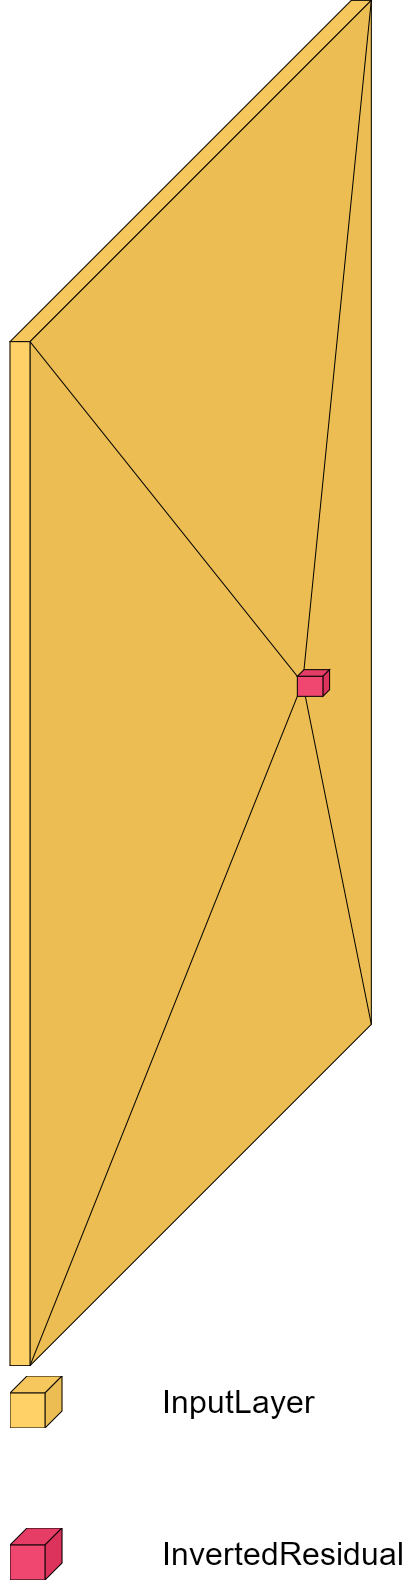

In [49]:
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 32)
visualkeras.layered_view(model2, legend=True, font=font, spacing=100, to_file='output.png')

In [34]:
def get_model3(filters = 256, strides=128, expansion_factor =6):
    img_height = 256
    img_width = 256
    img_channels = 3
    
    input_shape = (img_height, img_width, img_channels)
    img_input = k.Input(shape=input_shape)
    
    ptwise_conv1 = Conv2D(filters=int(img_channels*expansion_factor),
        	                       kernel_size=1, use_bias=False)
    dwise = DepthwiseConv2D(kernel_size=3, strides=strides,
        	                         padding='same', use_bias=False)
    ptwise_conv2 = Conv2D(filters=filters, kernel_size=1, use_bias=False)

    bn1 = BatchNormalization()
    bn2 = BatchNormalization()
    bn3 = BatchNormalization()
    
    x = ptwise_conv1(img_input)
    x = bn1(x)
    x = tf.nn.relu6(x)

        # Spatial filtering
    x = dwise(x)
    x = bn2(x)
    x = tf.nn.relu6(x)

        # Projection back to low-dimensional space w/ linear activation
    x = ptwise_conv2(x)
    x = bn3(x)

        # Residual connection if i/o have same spatial and depth dims
    if img_input.shape[1:] == x.shape[1:]:
        x += img_input
    return x
    
    model = models.Model(img_input, outputs=x)

    return model

In [37]:
import keras as k
from keras import models
from keras import layers
from keras import utils
opt = k.optimizers.Adam(learning_rate=1e-3)
model3 = get_model3()

In [38]:
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 32)
visualkeras.layered_view(model3, legend=True, font=font, spacing=100, to_file='output.png')

AttributeError: 'Tensor' object has no attribute 'layers'

# MobileNetV2

In [67]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import UpSampling2D,Concatenate
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
def model4():
    IMAGE_SIZE = 256

    inputs =  k.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = models.Model(inputs, x)
    return model

In [68]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [69]:
model4 = model4()

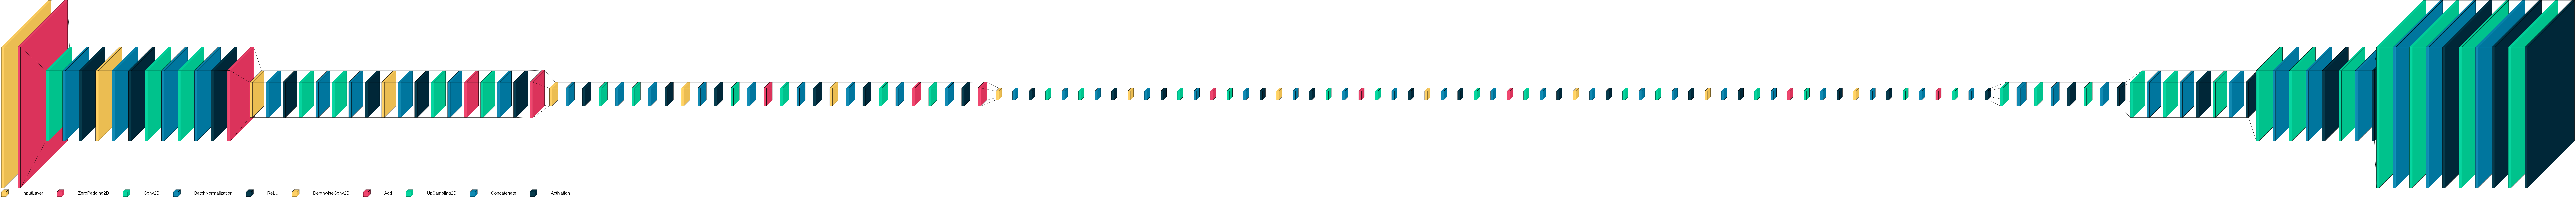

In [70]:
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 32)
visualkeras.layered_view(model4, legend=True, font=font, spacing=100, to_file='output.png')

In [71]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import UpSampling2D,Concatenate
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
def model5():
    IMAGE_SIZE = 256

    inputs =  k.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu", 'block_13_expand_relu']
    encoder_output = encoder.get_layer("block_16_project").output
    
    f = [8, 16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = models.Model(inputs, x)
    return model

In [72]:
model5 = model5()

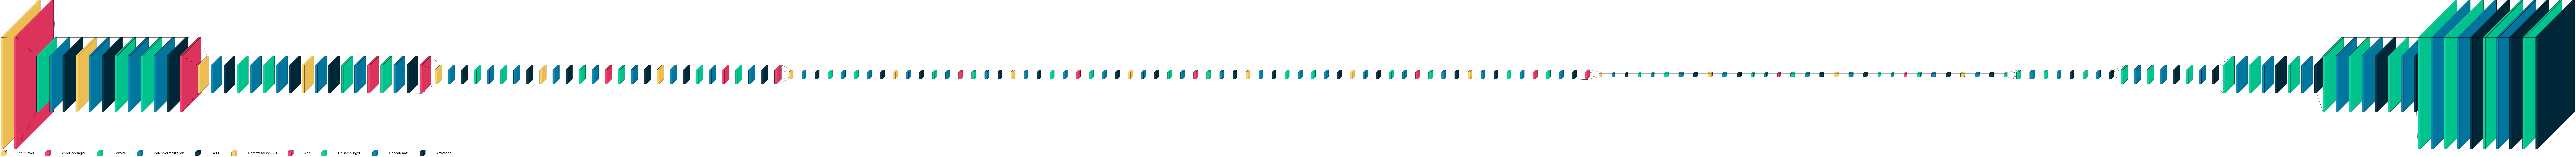

In [74]:
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 32)
visualkeras.layered_view(model5, legend=True, font=font, spacing=100, to_file='output.png')

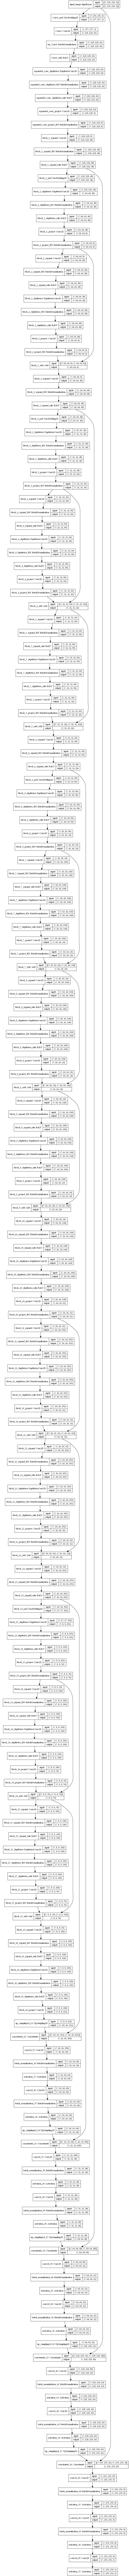

In [76]:
k.utils.plot_model(model5,show_shapes=True,rankdir='TB',to_file='model5.png')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.482492 to fit



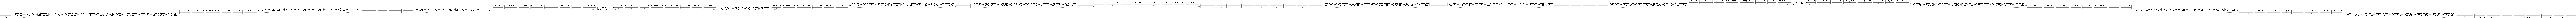

In [141]:
k.utils.plot_model(model5,show_shapes=True,rankdir='LR')

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, DepthwiseConv2D, BatchNormalization

class InvertedResidual(Layer):
    def __init__(self, filters, strides, expansion_factor=6, trainable=True,
    	         name=None, **kwargs):
        super(InvertedResidual, self).__init__(trainable=trainable, name=name, **kwargs)
        self.filters = filters
        self.strides = strides
        self.expansion_factor = expansion_factor	# allowed to be decimal value

    def build(self, input_shape):
        input_channels = int(input_shape[3])
        self.ptwise_conv1 = Conv2D(filters=int(input_channels*self.expansion_factor),
        	                       kernel_size=1, use_bias=False)
        self.dwise = DepthwiseConv2D(kernel_size=3, strides=self.strides,
        	                         padding='same', use_bias=False)
        self.ptwise_conv2 = Conv2D(filters=self.filters, kernel_size=1, use_bias=False)

        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()
        self.bn3 = BatchNormalization()

    def call(self, input_x):
        # Expansion to high-dimensional space
        x = self.ptwise_conv1(input_x)
        x = self.bn1(x)
        x = tf.nn.relu6(x)

        # Spatial filtering
        x = self.dwise(x)
        x = self.bn2(x)
        x = tf.nn.relu6(x)

        # Projection back to low-dimensional space w/ linear activation
        x = self.ptwise_conv2(x)
        x = self.bn3(x)

        # Residual connection if i/o have same spatial and depth dims
        if input_x.shape[1:] == x.shape[1:]:
            x += input_x
        return x

    def get_config(self):
        cfg = super(InvertedResidual, self).get_config()
        cfg.update({'filters': self.filters,
        	        'strides': self.strides,
        	        'expansion_factor': self.expansion_factor})
        return cfg

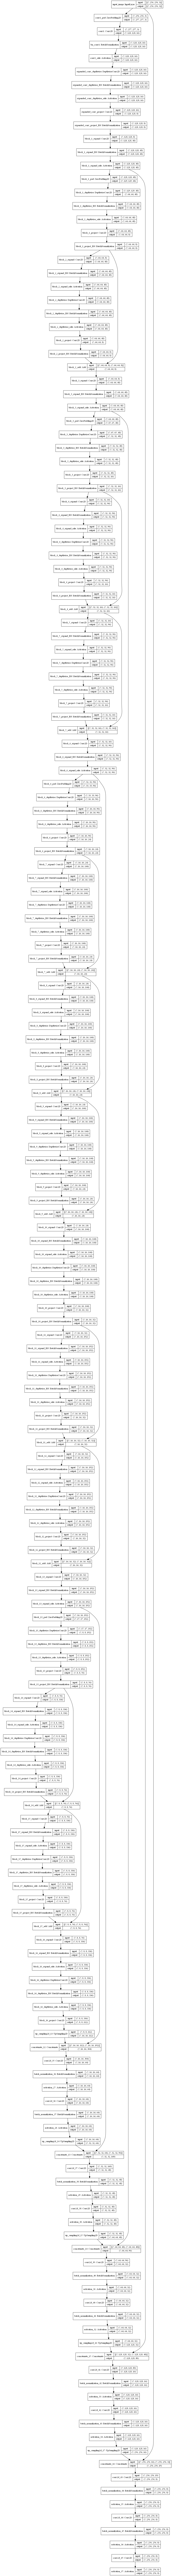

In [198]:
import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from tensorflow.python.keras import utils
from tensorflow.keras.layers import UpSampling2D,Concatenate, add
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, ZeroPadding2D, DepthwiseConv2D
from tensorflow.keras.activations import relu as ReLU

def get_model():
    IMAGE_SIZE = 256
    img_channels = 3
    
    img_input = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, img_channels), name="input_image")

    conv1_pad = ZeroPadding2D(padding=((0,1),(0,1)),name="conv1_pad")(img_input)
    conv1 = Conv2D(16, (130, 130),name="conv1")(conv1_pad)
    bn_conv1 = BatchNormalization(name="bn_conv1")(conv1)
    conv1_relu = Activation('relu',name="conv1_relu")(bn_conv1)
    
    expanded_conv_depthwise = DepthwiseConv2D(1,name="expanded_conv_depthwise")(conv1_relu)
    expanded_conv_depthwise_BN = BatchNormalization(name="expanded_conv_depthwise_BN")(expanded_conv_depthwise)
    expanded_conv_depthwise_relu = Activation('relu',name="expanded_conv_depthwise_relu")(expanded_conv_depthwise_BN)
    expanded_conv_project = Conv2D(8, (1, 1),name="expanded_conv_project")(expanded_conv_depthwise_relu)
    expanded_conv_project_BN = BatchNormalization(name="expanded_conv_project_BN")(expanded_conv_project)
    
    block_1_expand = Conv2D(48, (1, 1),name="block_1_expand")(expanded_conv_project_BN)
    block_1_expand_BN = BatchNormalization(name="block_1_expand_BN")(block_1_expand)
    block_1_expand_relu = Activation('relu',name="block_1_expand_relu")(block_1_expand_BN)
    block_1_pad = ZeroPadding2D(padding=((0,1),(0,1)),name="block_1_pad")(block_1_expand_relu)
    block_1_depthwise = DepthwiseConv2D(66,name="block_1_depthwise")(block_1_pad)
    block_1_depthwise_BN = BatchNormalization(name="block_1_depthwise_BN")(block_1_depthwise)
    block_1_depthwise_relu = Activation('relu',name="block_1_depthwise_relu")(block_1_depthwise_BN)
    block_1_project = Conv2D(8, (1, 1),name="block_1_project")(block_1_depthwise_relu)
    block_1_project_BN = BatchNormalization(name="block_1_project_BN")(block_1_project)
    
    block_2_expand = Conv2D(48, (1, 1),name="block_2_expand")(block_1_project_BN)
    block_2_expand_BN = BatchNormalization(name="block_2_expand_BN")(block_2_expand)
    block_2_expand_relu = Activation('relu',name="block_2_expand_relu")(block_2_expand_BN)
    block_2_depthwise = DepthwiseConv2D(1,name="block_2_depthwise")(block_2_expand_relu)
    block_2_depthwise_BN = BatchNormalization(name="block_2_depthwise_BN")(block_2_depthwise)
    block_2_depthwise_relu = Activation('relu',name="block_2_depthwise_relu")(block_2_depthwise_BN)
    block_2_project = Conv2D(8, (1, 1),name="block_2_project")(block_2_depthwise_relu)
    block_2_project_BN = BatchNormalization(name="block_2_project_BN")(block_2_project)
    
    block_2_add = add([block_2_project_BN,block_1_project_BN],name="block_2_add")
    
    block_3_expand = Conv2D(48, (1, 1),name="block_3_expand")(block_2_add)
    block_3_expand_BN = BatchNormalization(name="block_3_expand_BN")(block_3_expand)
    block_3_expand_relu = Activation('relu',name="block_3_expand_relu")(block_3_expand_BN)
    block_3_pad = ZeroPadding2D(padding=((0,1),(0,1)),name="block_3_pad")(block_3_expand_relu)
    block_3_depthwise = DepthwiseConv2D(34,name="block_3_depthwise")(block_3_pad)
    block_3_depthwise_BN = BatchNormalization(name="block_3_depthwise_BN")(block_3_depthwise)
    block_3_depthwise_relu = Activation('relu',name="block_3_depthwise_relu")(block_3_depthwise_BN)
    block_3_project = Conv2D(16, (1, 1),name="block_3_project")(block_3_depthwise_relu)
    block_3_project_BN = BatchNormalization(name="block_3_project_BN")(block_3_project)
    
    block_4_expand = Conv2D(96, (1, 1),name="block_4_expand")(block_3_project_BN)
    block_4_expand_BN = BatchNormalization(name="block_4_expand_BN")(block_4_expand)
    block_4_expand_relu = Activation('relu',name="block_4_expand_relu")(block_4_expand_BN)
    block_4_depthwise = DepthwiseConv2D(1,name="block_4_depthwise")(block_4_expand_relu)
    block_4_depthwise_BN = BatchNormalization(name="block_4_depthwise_BN")(block_4_depthwise)
    block_4_depthwise_relu = Activation('relu',name="block_4_depthwise_relu")(block_4_depthwise_BN)
    block_4_project = Conv2D(16, (1, 1),name="block_4_project")(block_4_depthwise_relu)
    block_4_project_BN = BatchNormalization(name="block_4_project_BN")(block_4_project)
    
    block_4_add = add([block_4_project_BN,block_3_project_BN],name="block_4_add")
    
    block_5_expand = Conv2D(96, (1, 1),name="block_5_expand")(block_4_add)
    block_5_expand_BN = BatchNormalization(name="block_5_expand_BN")(block_5_expand)
    block_5_expand_relu = Activation('relu',name="block_5_expand_relu")(block_5_expand_BN)
    block_5_depthwise = DepthwiseConv2D(1,name="block_5_depthwise")(block_5_expand_relu)
    block_5_depthwise_BN = BatchNormalization(name="block_5_depthwise_BN")(block_5_depthwise)
    block_5_depthwise_relu = Activation('relu',name="block_5_depthwise_relu")(block_5_depthwise_BN)
    block_5_project = Conv2D(16, (1, 1),name="block_5_project")(block_5_depthwise_relu)
    block_5_project_BN = BatchNormalization(name="block_5_project_BN")(block_5_project)
    
    block_5_add = add([block_5_project_BN,block_4_add],name="block_5_add")
    
    block_6_expand = Conv2D(96, (1, 1),name="block_6_expand")(block_5_add)
    block_6_expand_BN = BatchNormalization(name="block_6_expand_BN")(block_6_expand)
    block_6_expand_relu = Activation('relu',name="block_6_expand_relu")(block_6_expand_BN)
    block_6_pad = ZeroPadding2D(padding=((0,1),(0,1)),name="block_6_pad")(block_6_expand_relu)
    block_6_depthwise = DepthwiseConv2D(18,name="block_6_depthwise")(block_6_pad)
    block_6_depthwise_BN = BatchNormalization(name="block_6_depthwise_BN")(block_6_depthwise)
    block_6_depthwise_relu = Activation('relu',name="block_6_depthwise_relu")(block_6_depthwise_BN)
    block_6_project = Conv2D(24, (1, 1),name="block_6_project")(block_6_depthwise_relu)
    block_6_project_BN = BatchNormalization(name="block_6_project_BN")(block_6_project)
    
    block_7_expand = Conv2D(144, (1, 1),name="block_7_expand")(block_6_project_BN)
    block_7_expand_BN = BatchNormalization(name="block_7_expand_BN")(block_7_expand)
    block_7_expand_relu = Activation('relu',name="block_7_expand_relu")(block_7_expand_BN)
    block_7_depthwise = DepthwiseConv2D(1,name="block_7_depthwise")(block_7_expand_relu)
    block_7_depthwise_BN = BatchNormalization(name="block_7_depthwise_BN")(block_7_depthwise)
    block_7_depthwise_relu = Activation('relu',name="block_7_depthwise_relu")(block_7_depthwise_BN)
    block_7_project = Conv2D(24, (1, 1),name="block_7_project")(block_7_depthwise_relu)
    block_7_project_BN = BatchNormalization(name="block_7_project_BN")(block_7_project)
    
    block_7_add = add([block_7_project_BN,block_6_project_BN],name="block_7_add")
    
    block_8_expand = Conv2D(144, (1, 1),name="block_8_expand")(block_7_add)
    block_8_expand_BN = BatchNormalization(name="block_8_expand_BN")(block_8_expand)
    block_8_expand_relu = Activation('relu',name="block_8_expand_relu")(block_8_expand_BN)
    block_8_depthwise = DepthwiseConv2D(1,name="block_8_depthwise")(block_8_expand_relu)
    block_8_depthwise_BN = BatchNormalization(name="block_8_depthwise_BN")(block_8_depthwise)
    block_8_depthwise_relu = Activation('relu',name="block_8_depthwise_relu")(block_8_depthwise_BN)
    block_8_project = Conv2D(24, (1, 1),name="block_8_project")(block_8_depthwise_relu)
    block_8_project_BN = BatchNormalization(name="block_8_project_BN")(block_8_project)
    
    block_8_add = add([block_8_project_BN,block_7_add],name="block_8_add")
    
    block_9_expand = Conv2D(144, (1, 1),name="block_9_expand")(block_8_add)
    block_9_expand_BN = BatchNormalization(name="block_9_expand_BN")(block_9_expand)
    block_9_expand_relu = Activation('relu',name="block_9_expand_relu")(block_9_expand_BN)
    block_9_depthwise = DepthwiseConv2D(1,name="block_9_depthwise")(block_9_expand_relu)
    block_9_depthwise_BN = BatchNormalization(name="block_9_depthwise_BN")(block_9_depthwise)
    block_9_depthwise_relu = Activation('relu',name="block_9_depthwise_relu")(block_9_depthwise_BN)
    block_9_project = Conv2D(24, (1, 1),name="block_9_project")(block_9_depthwise_relu)
    block_9_project_BN = BatchNormalization(name="block_9_project_BN")(block_9_project)
    
    block_9_add = add([block_9_project_BN,block_8_add],name="block_9_add")
    
    block_10_expand = Conv2D(144, (1, 1),name="block_10_expand")(block_9_add)
    block_10_expand_BN = BatchNormalization(name="block_10_expand_BN")(block_10_expand)
    block_10_expand_relu = Activation('relu',name="block_10_expand_relu")(block_10_expand_BN)
    block_10_depthwise = DepthwiseConv2D(1,name="block_10_depthwise")(block_10_expand_relu)
    block_10_depthwise_BN = BatchNormalization(name="block_10_depthwise_BN")(block_10_depthwise)
    block_10_depthwise_relu = Activation('relu',name="block_10_depthwise_relu")(block_10_depthwise_BN)
    block_10_project = Conv2D(32, (1, 1),name="block_10_project")(block_10_depthwise_relu)
    block_10_project_BN = BatchNormalization(name="block_10_project_BN")(block_10_project)
    
    block_11_expand = Conv2D(192, (1, 1),name="block_11_expand")(block_10_project_BN)
    block_11_expand_BN = BatchNormalization(name="block_11_expand_BN")(block_11_expand)
    block_11_expand_relu = Activation('relu',name="block_11_expand_relu")(block_11_expand_BN)
    block_11_depthwise = DepthwiseConv2D(1,name="block_11_depthwise")(block_11_expand_relu)
    block_11_depthwise_BN = BatchNormalization(name="block_11_depthwise_BN")(block_11_depthwise)
    block_11_depthwise_relu = Activation('relu',name="block_11_depthwise_relu")(block_11_depthwise_BN)
    block_11_project = Conv2D(32, (1, 1),name="block_11_project")(block_11_depthwise_relu)
    block_11_project_BN = BatchNormalization(name="block_11_project_BN")(block_11_project)
    
    block_11_add = add([block_11_project_BN,block_10_project_BN],name="block_11_add")
    
    block_12_expand = Conv2D(192, (1, 1),name="block_12_expand")(block_11_add)
    block_12_expand_BN = BatchNormalization(name="block_12_expand_BN")(block_12_expand)
    block_12_expand_relu = Activation('relu',name="block_12_expand_relu")(block_12_expand_BN)
    block_12_depthwise = DepthwiseConv2D(1,name="block_12_depthwise")(block_12_expand_relu)
    block_12_depthwise_BN = BatchNormalization(name="block_12_depthwise_BN")(block_12_depthwise)
    block_12_depthwise_relu = Activation('relu',name="block_12_depthwise_relu")(block_12_depthwise_BN)
    block_12_project = Conv2D(32, (1, 1),name="block_12_project")(block_12_depthwise_relu)
    block_12_project_BN = BatchNormalization(name="block_12_project_BN")(block_12_project)
    
    block_12_add = add([block_12_project_BN,block_11_add],name="block_12_add")
    
    block_13_expand = Conv2D(192, (1, 1),name="block_13_expand")(block_12_add)
    block_13_expand_BN = BatchNormalization(name="block_13_expand_BN")(block_13_expand)
    block_13_expand_relu = Activation('relu',name="block_13_expand_relu")(block_13_expand_BN)
    block_13_pad = ZeroPadding2D(padding=((0,1),(0,1)),name="block_13_pad")(block_13_expand_relu)
    block_13_depthwise = DepthwiseConv2D(10,name="block_13_depthwise")(block_13_pad)
    block_13_depthwise_BN = BatchNormalization(name="block_13_depthwise_BN")(block_13_depthwise)
    block_13_depthwise_relu = Activation('relu',name="block_13_depthwise_relu")(block_13_depthwise_BN)
    block_13_project = Conv2D(56, (1, 1),name="block_13_project")(block_13_depthwise_relu)
    block_13_project_BN = BatchNormalization(name="block_13_project_BN")(block_13_project)

    block_14_expand = Conv2D(336, (1, 1),name="block_14_expand")(block_13_project_BN)
    block_14_expand_BN = BatchNormalization(name="block_14_expand_BN")(block_14_expand)
    block_14_expand_relu = Activation('relu',name="block_14_expand_relu")(block_14_expand_BN)
    block_14_depthwise = DepthwiseConv2D(1,name="block_14_depthwise")(block_14_expand_relu)
    block_14_depthwise_BN = BatchNormalization(name="block_14_depthwise_BN")(block_14_depthwise)
    block_14_depthwise_relu = Activation('relu',name="block_14_depthwise_relu")(block_14_depthwise_BN)
    block_14_project = Conv2D(56, (1, 1),name="block_14_project")(block_14_depthwise_relu)
    block_14_project_BN = BatchNormalization(name="block_14_project_BN")(block_14_project)
    
    block_14_add = add([block_14_project_BN,block_13_project_BN],name="block_14_add")
    
    block_15_expand = Conv2D(336, (1, 1),name="block_15_expand")(block_14_add)
    block_15_expand_BN = BatchNormalization(name="block_15_expand_BN")(block_15_expand)
    block_15_expand_relu = Activation('relu',name="block_15_expand_relu")(block_15_expand_BN)
    block_15_depthwise = DepthwiseConv2D(1,name="block_15_depthwise")(block_15_expand_relu)
    block_15_depthwise_BN = BatchNormalization(name="block_15_depthwise_BN")(block_15_depthwise)
    block_15_depthwise_relu = Activation('relu',name="block_15_depthwise_relu")(block_15_depthwise_BN)
    block_15_project = Conv2D(56, (1, 1),name="block_15_project")(block_15_depthwise_relu)
    block_15_project_BN = BatchNormalization(name="block_15_project_BN")(block_15_project)
    
    block_15_add = add([block_15_project_BN,block_14_add],name="block_15_add")
    
    block_16_expand = Conv2D(336, (1, 1),name="block_16_expand")(block_15_add)
    block_16_expand_BN = BatchNormalization(name="block_16_expand_BN")(block_16_expand)
    block_16_expand_relu = Activation('relu',name="block_16_expand_relu")(block_16_expand_BN)
    block_16_depthwise = DepthwiseConv2D(1,name="block_16_depthwise")(block_16_expand_relu)
    block_16_depthwise_BN = BatchNormalization(name="block_16_depthwise_BN")(block_16_depthwise)
    block_16_depthwise_relu = Activation('relu',name="block_16_depthwise_relu")(block_16_depthwise_BN)
    block_16_project = Conv2D(112, (1, 1),name="block_16_project")(block_16_depthwise_relu)
    
    up_sampling2d_13 = UpSampling2D(size=(2, 2),name="up_sampling2d_13")(block_16_project)
    
    concatenate_12 = Concatenate(name="concatenate_12")([up_sampling2d_13, block_13_expand_relu])
    
    conv2d_35 = Conv2D(64, (1, 1),name="conv2d_35")(concatenate_12)
    batch_normalization_36 = BatchNormalization(name="batch_normalization_36")(conv2d_35)
    activation_27 = Activation('relu',name="activation_27")(batch_normalization_36)
    
    conv2d_36 = Conv2D(64, (1, 1),name="conv2d_36")(activation_27)
    batch_normalization_37 = BatchNormalization(name="batch_normalization_37")(conv2d_36)
    activation_28 = Activation('relu',name="activation_28")(batch_normalization_37)
    
    up_sampling2d_14 = UpSampling2D(size=(2, 2),name="up_sampling2d_14")(activation_28)
    
    concatenate_13 = Concatenate(name="concatenate_13")([up_sampling2d_14, block_6_expand_relu])
    
    conv2d_37 = Conv2D(48, (1, 1),name="conv2d_37")(concatenate_13)
    batch_normalization_38 = BatchNormalization(name="batch_normalization_38")(conv2d_37)
    activation_29 = Activation('relu',name="activation_29")(batch_normalization_38)
    
    conv2d_38 = Conv2D(48, (1, 1),name="conv2d_38")(activation_29)
    batch_normalization_39 = BatchNormalization(name="batch_normalization_39")(conv2d_38)
    activation_30 = Activation('relu',name="activation_30")(conv2d_38)
    
    up_sampling2d_15 = UpSampling2D(size=(2, 2),name="up_sampling2d_15")(activation_30)
    
    concatenate_14 = Concatenate(name="concatenate_14")([up_sampling2d_15, block_3_expand_relu])
    
    conv2d_39 = Conv2D(32, (1, 1),name="conv2d_39")(concatenate_14)
    batch_normalization_40 = BatchNormalization(name="batch_normalization_40")(conv2d_39)
    activation_31 = Activation('relu',name="activation_31")(batch_normalization_40)
    
    conv2d_40 = Conv2D(32, (1, 1),name="conv2d_40")(activation_31)
    batch_normalization_41 = BatchNormalization(name="batch_normalization_41")(conv2d_40)
    activation_32 = Activation('relu',name="activation_32")(batch_normalization_41)
    
    up_sampling2d_16 = UpSampling2D(size=(2, 2),name="up_sampling2d_16")(activation_32)
    
    concatenate_15 = Concatenate(name="concatenate_15")([up_sampling2d_16, block_1_expand_relu])
    
    conv2d_41 = Conv2D(16, (1, 1),name="conv2d_41")(concatenate_15)
    batch_normalization_42 = BatchNormalization(name="batch_normalization_42")(conv2d_41)
    activation_33 = Activation('relu',name="activation_33")(batch_normalization_42)
    
    conv2d_42 = Conv2D(16, (1, 1),name="conv2d_42")(activation_33)
    batch_normalization_43 = BatchNormalization(name="batch_normalization_43")(conv2d_42)
    activation_34 = Activation('relu',name="activation_34")(batch_normalization_43)
    
    up_sampling2d_17 = UpSampling2D(size=(2, 2),name="up_sampling2d_17")(activation_34)
    
    concatenate_16 = Concatenate(name="concatenate_16")([up_sampling2d_17, img_input])
    
    conv2d_43 = Conv2D(8, (1, 1),name="conv2d_43")(concatenate_16)
    batch_normalization_44 = BatchNormalization(name="batch_normalization_44")(conv2d_43)
    activation_35 = Activation('relu',name="activation_35")(batch_normalization_44)
    
    conv2d_44 = Conv2D(8, (1, 1),name="conv2d_44")(activation_35)
    batch_normalization_45 = BatchNormalization(name="batch_normalization_45")(conv2d_44)
    activation_36 = Activation('relu',name="activation_36")(batch_normalization_45)
    
    conv2d_45 = Conv2D(8, (1, 1),name="conv2d_45")(activation_36)
    activation_37 = Activation('relu',name="activation_37")(conv2d_45)
    
    model = models.Model(img_input, outputs=activation_37)
    

    return model

model6 = get_model()
k.utils.plot_model(model6,show_shapes=True,rankdir='TB')

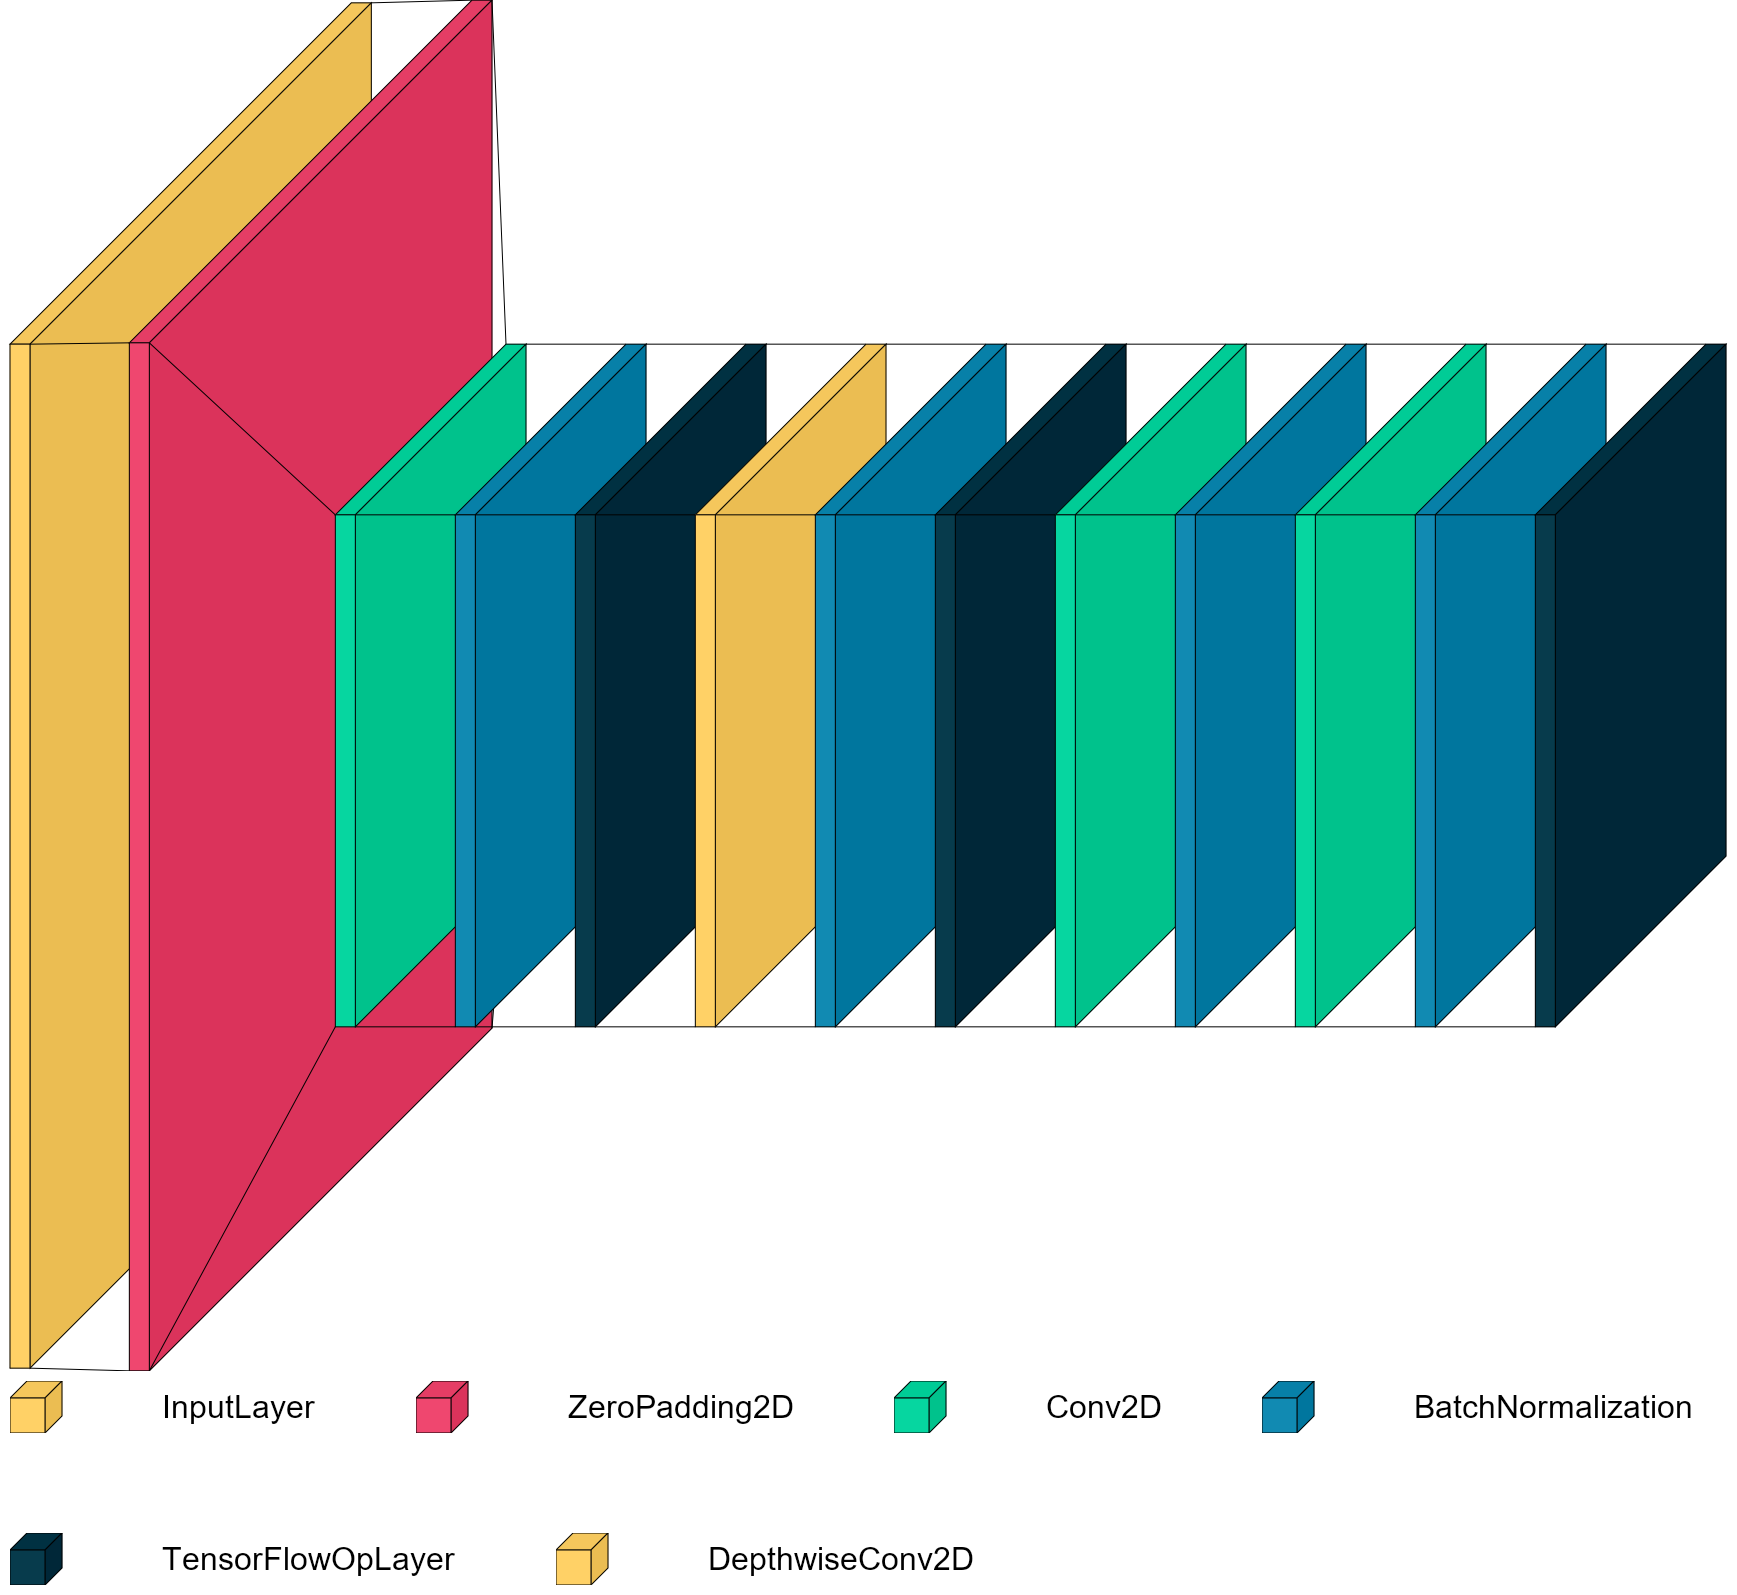

In [140]:
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 32)
visualkeras.layered_view(model6, legend=True, font=font, spacing=100)

# TF model

In [39]:
import tensorflow as tf
from tensorflow.examples.tensorflow_examples.models.pix2pix import pix2pix

In [41]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

In [24]:
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

up_stack = [
        pix2pix.upsample(512, 3),  # 4x4 -> 8x8
        pix2pix.upsample(256, 3),  # 8x8 -> 16x16
        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]

In [30]:
print(base_model_outputs)

[<tf.Tensor 'block_1_expand_relu/Relu6_1:0' shape=(None, 64, 64, 96) dtype=float32>, <tf.Tensor 'block_3_expand_relu/Relu6_1:0' shape=(None, 32, 32, 144) dtype=float32>, <tf.Tensor 'block_6_expand_relu/Relu6_1:0' shape=(None, 16, 16, 192) dtype=float32>, <tf.Tensor 'block_13_expand_relu/Relu6_1:0' shape=(None, 8, 8, 576) dtype=float32>, <tf.Tensor 'block_16_project/Conv2D_1:0' shape=(None, 4, 4, 320) dtype=float32>]


In [27]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
#   inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [28]:
OUTPUT_CHANNELS = 5
model = unet_model(OUTPUT_CHANNELS)

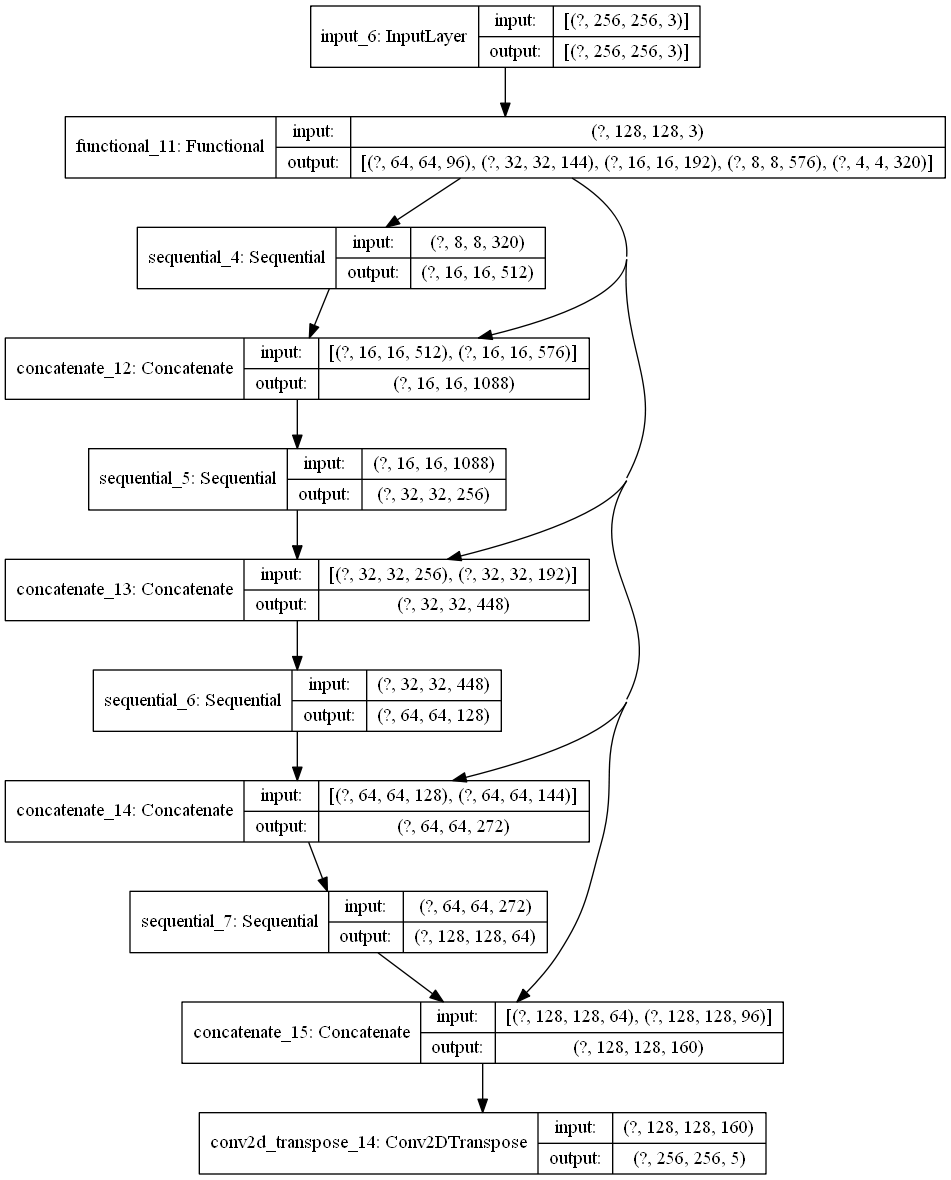

In [31]:
tf.keras.utils.plot_model(model,show_shapes=True,rankdir='TB')

In [29]:
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 32)
visualkeras.layered_view(model, legend=True, font=font, spacing=100, to_file='output.png')

RuntimeError: not supported tensor shape [(None, 64, 64, 96), (None, 32, 32, 144), (None, 16, 16, 192), (None, 8, 8, 576), (None, 4, 4, 320)]

# TensorBoard

In [32]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [33]:
from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras

In [34]:
import tensorboard
tensorboard.__version__

'2.3.0'

In [38]:
load_model = tf.keras.models.load_model('C:/Users/span/Documents/CNN/tmp/Model_orig_tensflow_checkpoint.h5')

In [39]:
load_model.save('C:/Users/span/Documents/CNN/tmp/saved_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:/Users/span/Documents/CNN/tmp/assets


In [40]:
logdir="C:/Users/span/Documents/CNN/tmp/saved_model/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [42]:
%tensorboard --logdir=C:\Users\span\Documents\CNN\tmp\tensorflow_logdir

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2021-06-11 16:46:18.834421: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library cudart64_101.dll
Traceback (most recent call last):
  File "c:\users\span\anaconda3\envs\tf-n-gpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\span\anaconda3\envs\tf-n-gpu\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\span\anaconda3\envs\tf-n-gpu\Scripts\tensorboard.exe\__main__.py", line 7, in <module>
  File "c:\users\span\anaconda3\envs\tf-n-gpu\lib\site-packages\tensorboard\main.py", line 75, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "c:\users\span\anaconda3\envs\tf-n-gpu\lib\site-packages\absl\app.py", line 300, in run
    _run_main(main, args)
  File "c:\users\span\anaconda3\envs\tf-n-gpu\lib\site-packages\absl\app.py", line 251, in _run_main
    sys.exit(main

In [1]:
# ValueError: Duplicate plugins for name projector
# https://www.programmersought.com/article/84384042662/
import pkg_resources
 
for entry_point in pkg_resources.iter_entry_points('tensorboard_plugins'):
    print(entry_point.dist)

tensorboard 2.3.0
tensorboard-plugin-wit 1.7.0


# net2vis

In [ ]:
# https://github.com/viscom-ulm/Net2Vis